In [2]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import numpy as np
from math import ceil
from model import build_AE
from utils.loader import KFoldDataset
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.loader import TestDataset

In [3]:
# --------------------------------------------------------------------------
# Preparing data
field_names = ['p_seabass', 'sea', 'barrel', 'lng', 'noon']
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((200,200), Image.BICUBIC),   # Resize images to 200x200
    transforms.ToTensor(),  # Convert images to tensor (values between 0 and 1)
])
testing_set = TestDataset('../data', transform=transform)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)
iters_per_epoch = ceil(len(testing_set) / batch_size)
print(f'testing dataset total data: {len(testing_set)}')
training_set = KFoldDataset(root_dir='../data', field_names=field_names, k=0, train=True, transform=transform)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)
print(f'training dataset total data: {len(training_set)}')
# --------------------------------------------------------------------------

# --------------------------------------------------------------------------
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = build_AE()  # Make sure this matches the original model architecture
autoencoder.load_state_dict(torch.load('../saved/models/model_20240928_204659_99.pt', weights_only=True))
autoencoder.to(device)
# --------------------------------------------------------------------------

testing dataset total data: 200
training dataset total data: 880


Autoencoder(
  (encoder): Encoder(
    (layer1): EncoderLayer(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): EncoderLayer(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (decoder): Decoder(
    (layer2): DecoderLayer(
      (conv_transpose): ConvTranspose2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (layer3): DecoderLayer(
      (conv_transpose): ConvTranspose2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padd

## Draw each class image and reconstruct sub

Median sub: 218.60635375976562
Q3 (75th percentile) sub: 293.6462173461914


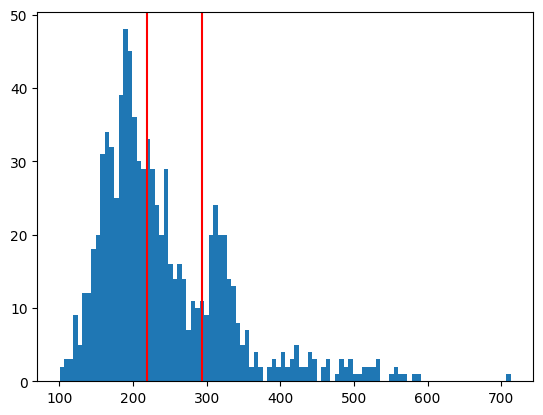

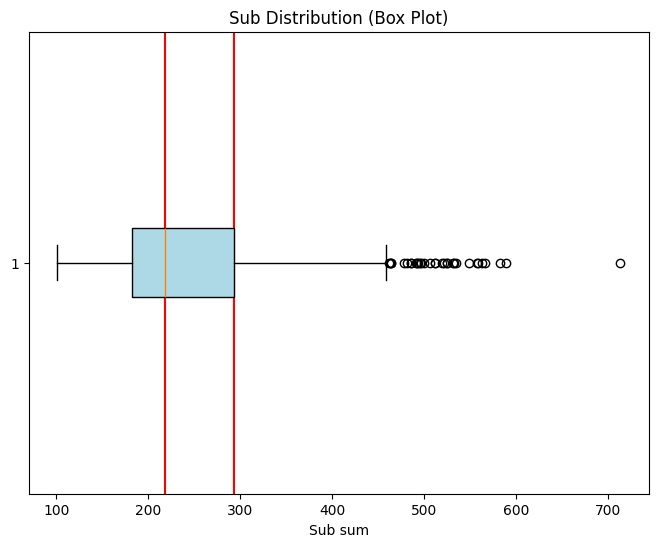

In [8]:
sum_list = []
with torch.no_grad():
    for inputs, targets, _ in training_loader:
        inputs = inputs.to(device)
        latent, recon = autoencoder(inputs)
        subt = torch.sum(torch.abs(inputs - recon), dim=[1, 2, 3])  # Compute subtracte for each image
        # print(f'inputs shape: {inputs.shape} recon shape: {recon.shape} subt shape: {subt.shape}')
        sum_list.extend(subt.cpu().numpy())  # Store the subtracte values


# Compute median and Q3 (75th percentile)
median_value = np.median(sum_list)
q3_value = np.percentile(sum_list, 75)
print(f"Median sub: {median_value}")
print(f"Q3 (75th percentile) sub: {q3_value}")

import matplotlib.pyplot as plt
plt.hist(sum_list, bins=100)
plt.axvline(x=median_value, color='r', linestyle='-')
plt.axvline(x=q3_value, color='r', linestyle='-')
plt.show()
# Create a box plot of MSE values
plt.figure(figsize=(8, 6))
plt.axvline(x=median_value, color='r', linestyle='-')
plt.axvline(x=q3_value, color='r', linestyle='-')
plt.boxplot(sum_list, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Sub Distribution (Box Plot)')
plt.xlabel('Sub sum')
plt.show()

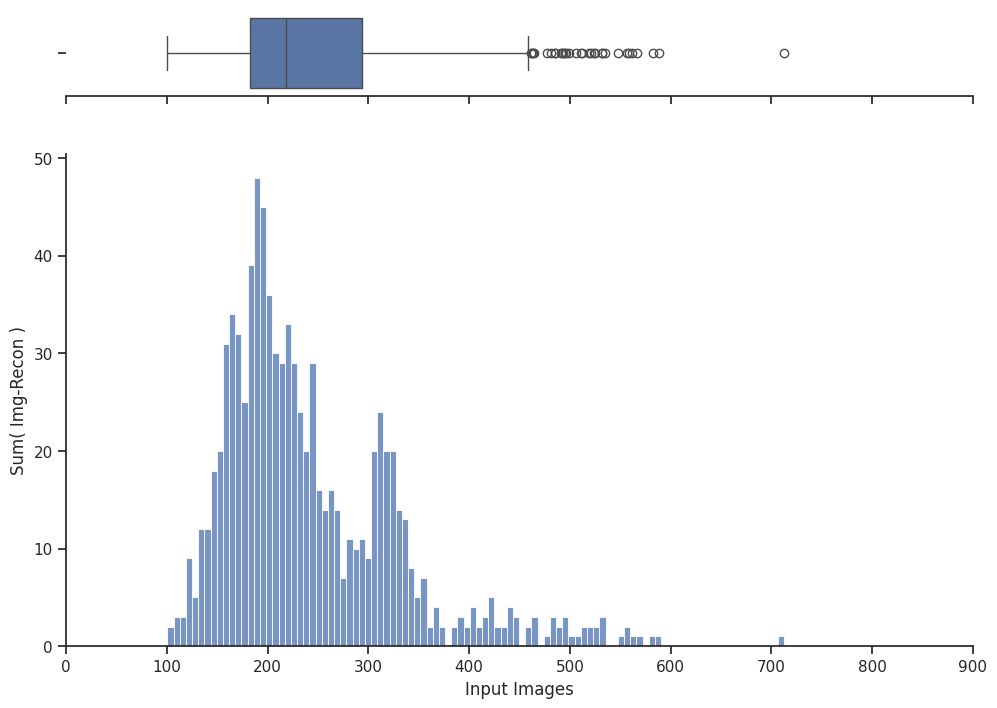

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme and figure size
sns.set_theme(style="ticks", rc={'figure.figsize': (11.7, 8.27)})

# Example data (replace this with your sum_list)
x = sum_list

# Create subplots: boxplot on top, histogram on the bottom
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

# Boxplot and histogram
sns.boxplot(x=x, ax=ax_box, vert=False, patch_artist=True)
sns.histplot(x=x, ax=ax_hist, bins=100)

# Set x-tick values and labels
ax_box.set(xticks=np.arange(0, 1000, 100))  # Boxplot x-ticks
ax_hist.set(xticks=np.arange(0, 1000, 100))  # Histogram x-ticks

# Set labels for the histogram
ax_hist.set(ylabel='Sum( Img-Recon )', xlabel='Input Images')

# Remove spines for cleaner look
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

# Show plot
plt.show()


## Draw each class distance distribution

Median MSE: 0.00016813761612866074
Q3 (75th percentile) MSE: 0.0002463265918777324


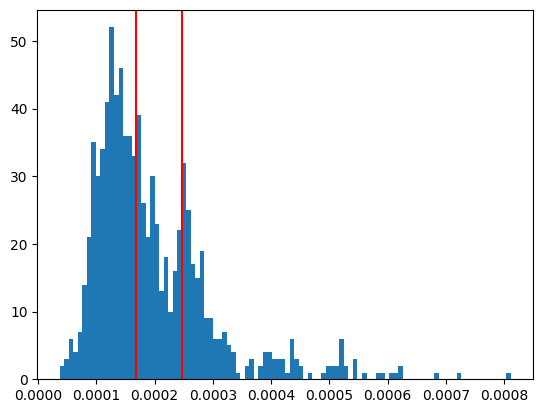

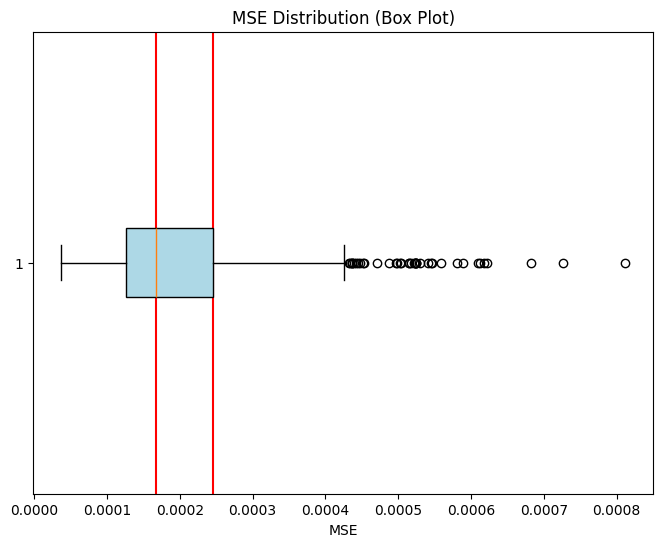

In [15]:
mse_list = []
with torch.no_grad():
    for inputs, targets, _ in training_loader:
        inputs = inputs.to(device)
        latent, recon = autoencoder(inputs)
        mse = torch.mean((inputs - recon) ** 2, dim=[1, 2, 3])  # Compute MSE for each image
        mse_list.extend(mse.cpu().numpy())  # Store the MSE values

# Compute median and Q3 (75th percentile)
median_value = np.median(mse_list)
q3_value = np.percentile(mse_list, 75)
print(f"Median MSE: {median_value}")
print(f"Q3 (75th percentile) MSE: {q3_value}")

import matplotlib.pyplot as plt
plt.hist(mse_list, bins=100)
plt.axvline(x=median_value, color='r', linestyle='-')
plt.axvline(x=q3_value, color='r', linestyle='-')
plt.show()
# Create a box plot of MSE values
plt.figure(figsize=(8, 6))
plt.axvline(x=median_value, color='r', linestyle='-')
plt.axvline(x=q3_value, color='r', linestyle='-')
plt.boxplot(mse_list, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('MSE Distribution (Box Plot)')
plt.xlabel('MSE')
plt.show()

In [27]:
autoencoder.eval()

# total five fields in test data
per_fields_latents = [[] for _ in range(5)]

mse_q3 = q3_value # 0.00011
with torch.no_grad():
    for _, imgs, field_idxs in training_loader:
        imgs:torch.Tensor = imgs.to(device)

        latents, recons = autoencoder(imgs)
        mse = torch.mean((imgs - recons) ** 2, dim=[1, 2, 3])  # Compute MSE for each image
        mse_fillter = (mse < mse_q3)
        
        # latent shape (batch size, channel, h, w) -> (batch size, channel, h*w)
        latents:torch.Tensor = latents.view((latents.shape[0], latents.shape[1], latents.shape[2]*latents.shape[2]))

        # Iterate over all possible field indices (0 to 4)
        for field_idx in range(5):
            # Get mask for current field_idx
            mask = (field_idxs == field_idx).to(device)
            keep = torch.logical_and(mse_fillter, mask)
            # Select images corresponding to this field index
            # selected_imgs_latent = latents[mask]
            selected_imgs_latent = latents[keep]
            selected_imgs_latent = selected_imgs_latent.detach()
            # selected_imgs_latent = selected_imgs_latent.detach().cpu().numpy()

            # Append the selected images to the corresponding list
            per_fields_latents[field_idx].extend(selected_imgs_latent)
print([len(i) for i in per_fields_latents])

[94, 111, 131, 150, 174]


In [28]:
# compute_mean_vector(MAV) Calculate the feature distribution for each channel.

# Assuming per_fields_latents is a list of tensors
latent_channels_number = 128
per_fields_mav = []

for field_latents in per_fields_latents:
    # Convert field_latents to a tensor if it's not already
    field_latents = torch.stack(field_latents)  # Shape: (N, C, F)

    # Compute the mean across the first dimension (N) for each channel
    channel_mean_vec = torch.mean(field_latents, dim=0)  # Shape: (C, F)

    # Convert to numpy (optional, depending on whether you need numpy or torch tensors)
    channel_mean_vec = channel_mean_vec.cpu().numpy()

    print(channel_mean_vec.shape)  # Should print (128, F)
    per_fields_mav.append(channel_mean_vec)
print(len(per_fields_mav), type(per_fields_mav[0]))

(16, 144)
(16, 144)
(16, 144)
(16, 144)
(16, 144)
5 <class 'numpy.ndarray'>


In [10]:
# compute_mean_vector(MAV) Calculate the distribution of each feature across different channels.

# Assuming per_fields_latents is a list of tensors
latent_channels_number = 16
per_fields_mav = []

for field_latents in per_fields_latents:
    # Convert field_latents to a tensor if it's not already
    field_latents = torch.stack(field_latents)  # Shape: (N, C, F)

    # Compute the mean across the first dimension (N) for each channel
    channel_mean_vec = torch.mean(field_latents, dim=0)  # Shape: (C, F)

    # Convert to numpy (optional, depending on whether you need numpy or torch tensors)
    channel_mean_vec = channel_mean_vec.cpu().numpy()

    print(channel_mean_vec.shape)  # Should print (128, F)
    per_fields_mav.append(channel_mean_vec)
print(len(per_fields_mav), type(per_fields_mav[0]))

(16, 144)
(16, 144)
(16, 144)
(16, 144)
(16, 144)
5 <class 'numpy.ndarray'>


In [6]:
# compute channel distances
import scipy.spatial.distance as spd

latent_channels_number = 16
per_fields_ch_dist = []
for field_latents in per_fields_latents:
    eucos_dist = []
    eu_dist = []
    cos_dist = []
    for channel in range(latent_channels_number):
        eu_channel, cos_channel, eu_cos_channel = [], [], []
        for i, feature in enumerate(field_latents):
            feature = feature.cpu().numpy()
            eu_channel += [spd.euclidean(channel_mean_vec[channel, :], feature[channel, :])]
            cos_channel += [spd.cosine(channel_mean_vec[channel, :]+1e-14, feature[channel, :]+1e-14)]
            eu_cos_channel += [spd.euclidean(channel_mean_vec[channel, :], feature[channel, :])/200. +
                            spd.cosine(channel_mean_vec[channel, :]+1e-14, feature[channel, :]+1e-14)]
        eu_dist += [eu_channel]
        cos_dist += [cos_channel]
        eucos_dist += [eu_cos_channel]

    eucos_dist = np.asarray(eucos_dist)
    eu_dist = np.asarray(eu_dist)
    cos_dist = np.asarray(cos_dist)

    assert eucos_dist.shape[0] == 16
    assert eu_dist.shape[0] == 16
    assert cos_dist.shape[0] == 16
    assert eucos_dist.shape[1] == len(field_latents)
    assert eu_dist.shape[1] == len(field_latents)
    assert cos_dist.shape[1] == len(field_latents)

    channel_distances = {'eucos': eucos_dist, 'cosine': cos_dist, 'euclidean':eu_dist}
    per_fields_ch_dist.append(channel_distances)
print(per_fields_ch_dist[0].get('eucos').shape)

print(per_fields_ch_dist[0].get('cosine'))

/home/samel/anaconda3/envs/ae-zero-shot/lib/python3.9/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: divide by zero encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


(16, 94)
[[0.00172473 0.00120787 0.00122691 ... 0.00133065 0.00149443 0.00097006]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00072092 0.00184048 0.00158489 ... 0.00177641 0.00201377 0.00026266]
 ...
 [0.00450684 0.00461048 0.00448757 ... 0.00530719 0.00499856 0.00267356]
 [0.20150597 0.20150597 0.20150597 ... 0.20150597 0.20150597 0.20150597]
 [0.00065019 0.00057506 0.00054898 ... 0.00053871 0.00060197 0.00032493]]


In [29]:
import scipy.spatial.distance as spd
import numpy as np
import torch

latent_channels_number = 16
per_fields_ch_dist = []

for field_latents in per_fields_latents:
    field_latents = torch.stack(field_latents)  # Shape: (N, C, F)
    field_latents_np = field_latents.cpu().numpy()  # Convert to NumPy

    eu_dist, cos_dist, eucos_dist = [], [], []
    
    for channel in range(latent_channels_number):
        # Select features for the current channel (shape: (N, F))
        channel_features = field_latents_np[:, channel, :]

        # Get mean vector for the current channel (shape: (F,))
        channel_mean = channel_mean_vec[channel, :]

        # Compute Euclidean and Cosine distances in a vectorized manner
        eu_channel = np.linalg.norm(channel_features - channel_mean, axis=1)  # Euclidean distance
        cos_channel = np.apply_along_axis(spd.cosine, 1, channel_features+1e-14, channel_mean+1e-14)  # Cosine distance
        eu_cos_channel = eu_channel / 200.0 + cos_channel  # Combined distance

        # Append to the lists
        eu_dist.append(eu_channel)
        cos_dist.append(cos_channel)
        eucos_dist.append(eu_cos_channel)

    # Convert lists to NumPy arrays and ensure shapes are correct
    eu_dist = np.asarray(eu_dist)      # Shape: (128, N)
    cos_dist = np.asarray(cos_dist)    # Shape: (128, N)
    eucos_dist = np.asarray(eucos_dist)  # Shape: (128, N)

    # Assertions to verify correct shapes
    assert eucos_dist.shape[0] == latent_channels_number
    assert eu_dist.shape[0] == latent_channels_number
    assert cos_dist.shape[0] == latent_channels_number
    assert eucos_dist.shape[1] == field_latents_np.shape[0]  # N is the number of samples
    assert eu_dist.shape[1] == field_latents_np.shape[0]
    assert cos_dist.shape[1] == field_latents_np.shape[0]

    # Store results in a dictionary
    channel_distances = {'eucos': eucos_dist, 'cosine': cos_dist, 'euclidean': eu_dist}
    per_fields_ch_dist.append(channel_distances)

# Print the shape of the first result for verification
print(per_fields_ch_dist[0].get('eucos').shape)


(16, 94)


/home/samel/anaconda3/envs/ae-zero-shot/lib/python3.9/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: divide by zero encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


In [19]:
# Calculate the distribution of each feature across different channels.

import scipy.spatial.distance as spd
import numpy as np
import torch

latent_features_number = 144
per_fields_f_dist = []

for field_latents in per_fields_latents:
    field_latents = torch.stack(field_latents)  # Shape: (N, C, F)
    field_latents_np = field_latents.cpu().numpy()  # Convert to NumPy

    eu_dist, cos_dist, eucos_dist = [], [], []
    
    for feature_id in range(latent_features_number):
        # Select channel for the current features (shape: (N, C))
        feature_channels = field_latents_np[:, :, feature_id]

        # Get mean vector for the current feature_id (shape: (C,))
        feature_mean = channel_mean_vec[:, feature_id]

        # Compute Euclidean and Cosine distances in a vectorized manner
        eu_channel = np.linalg.norm(feature_channels - feature_mean, axis=1)  # Euclidean distance
        cos_channel = np.apply_along_axis(spd.cosine, 1, feature_channels+1e-14, feature_mean+1e-14)  # Cosine distance
        eu_cos_channel = eu_channel / 200.0 + cos_channel  # Combined distance

        # Append to the lists
        eu_dist.append(eu_channel)
        cos_dist.append(cos_channel)
        eucos_dist.append(eu_cos_channel)

    # Convert lists to NumPy arrays and ensure shapes are correct
    eu_dist = np.asarray(eu_dist)      # Shape: (128, N)
    cos_dist = np.asarray(cos_dist)    # Shape: (128, N)
    eucos_dist = np.asarray(eucos_dist)  # Shape: (128, N)

    # Assertions to verify correct shapes
    assert eucos_dist.shape[0] == latent_features_number
    assert eu_dist.shape[0] == latent_features_number
    assert cos_dist.shape[0] == latent_features_number
    assert eucos_dist.shape[1] == field_latents_np.shape[0]  # N is the number of samples
    assert eu_dist.shape[1] == field_latents_np.shape[0]
    assert cos_dist.shape[1] == field_latents_np.shape[0]

    # Store results in a dictionary
    feature_distances = {'eucos': eucos_dist, 'cosine': cos_dist, 'euclidean': eu_dist}
    per_fields_f_dist.append(feature_distances)

# Print the shape of the first result for verification
print(per_fields_f_dist[0].get('eucos').shape)

(144, 94)


['p_seabass', 'sea', 'barrel', 'lng', 'noon']


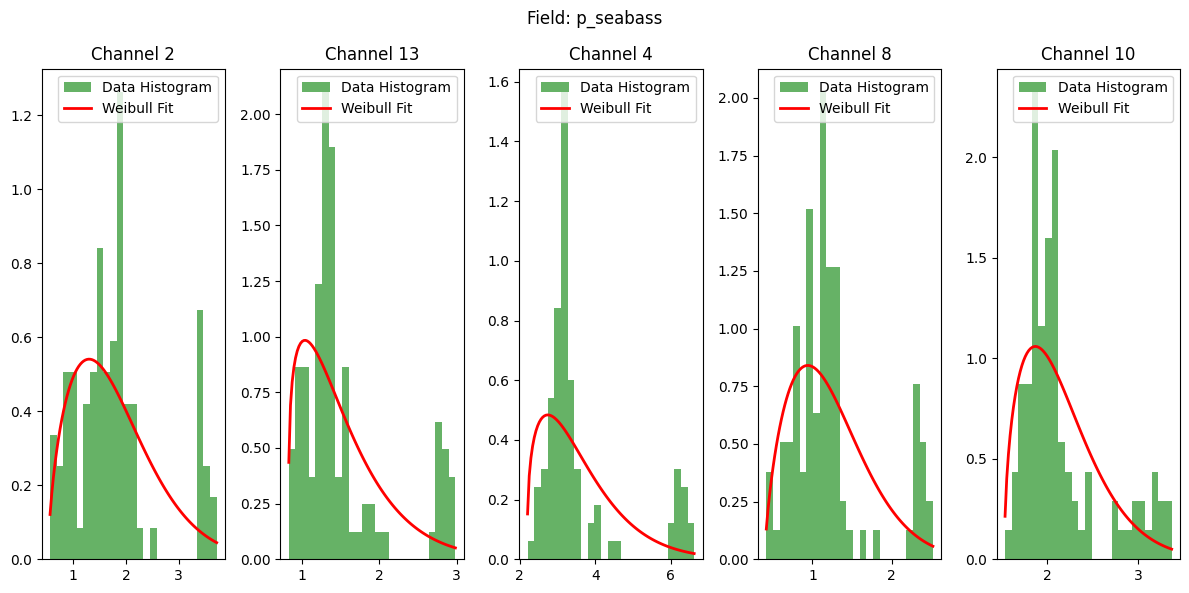

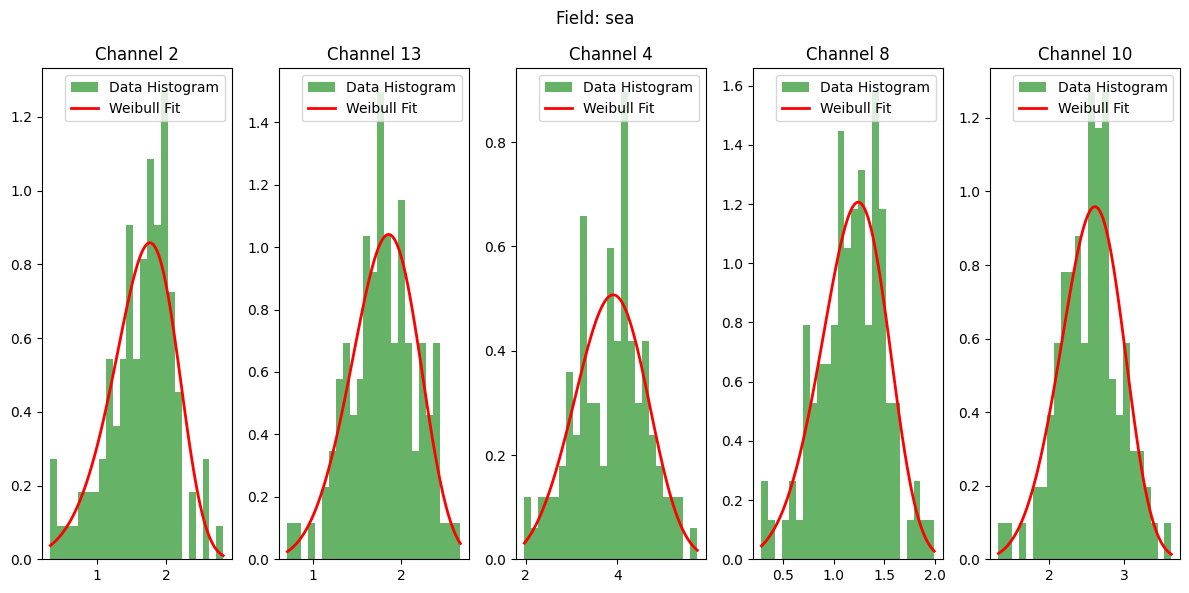

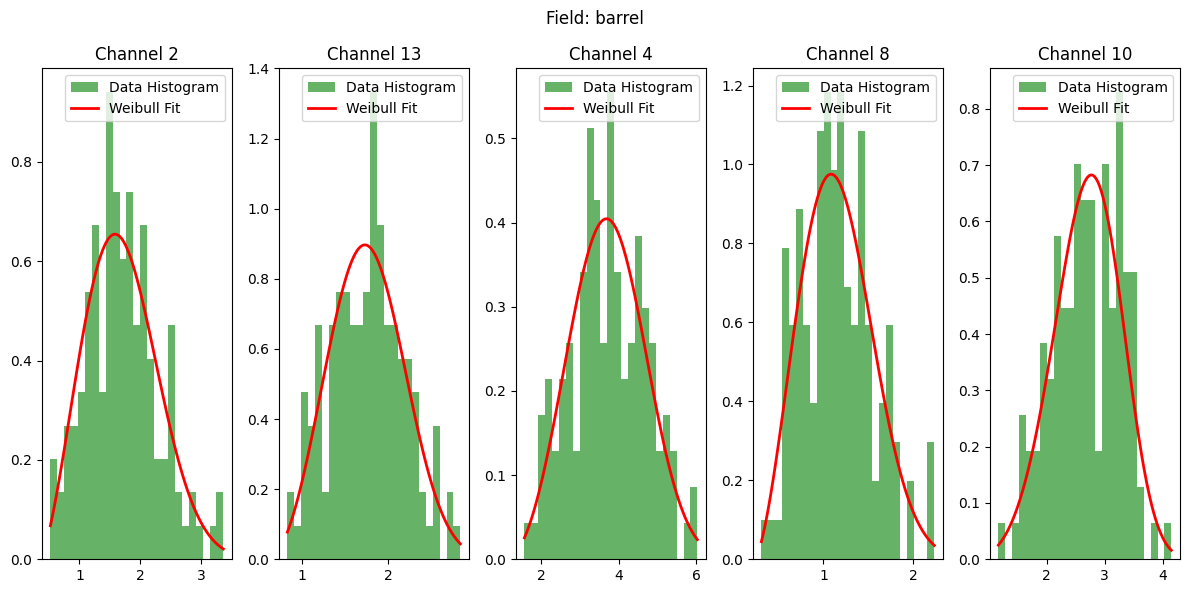

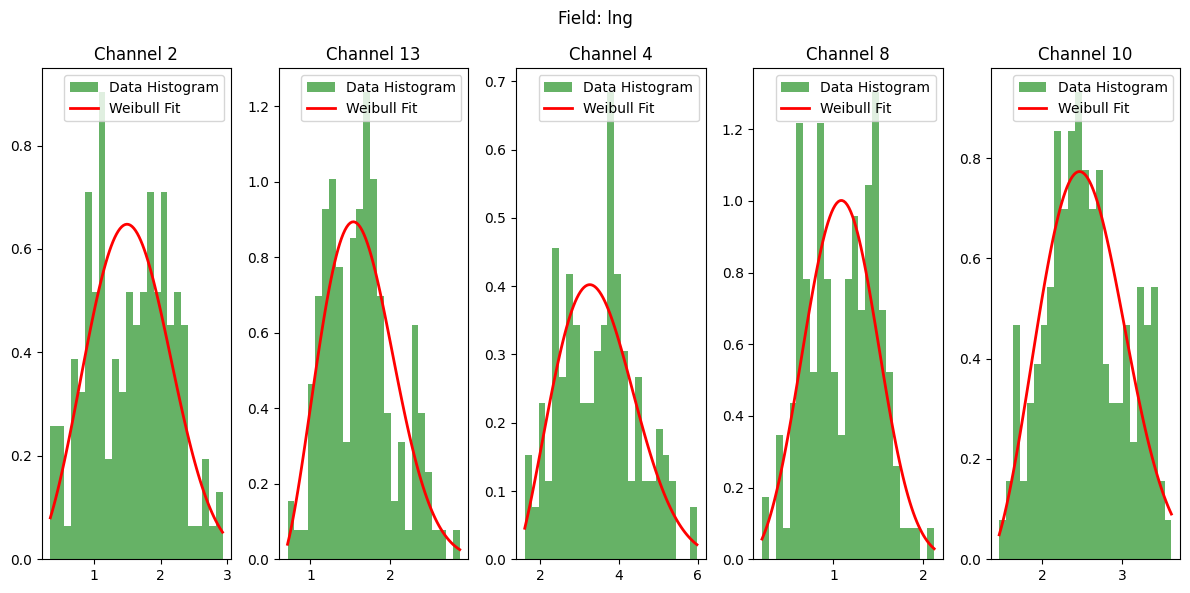

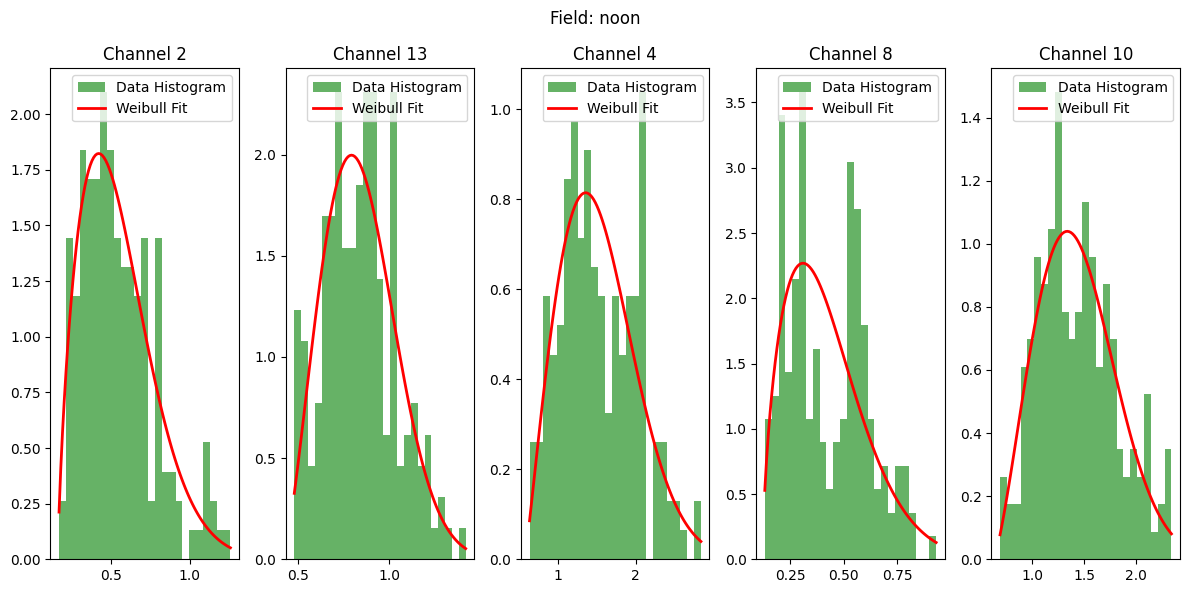

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Approach 1: Randomly sample a few channels and overlay Weibull fit
def plot_sampled_weibull_fit(eucos_dist, num_samples=5, features=False, field_name=''):
    # sampled_channels = np.random.choice(eucos_dist.shape[0], num_samples, replace=False)
    sampled_channels = [2, 13, 4, 8, 10] if not features else [0, 42, 44, 29, 55]
    plt.figure(figsize=(12, 6))
    for i, channel_idx in enumerate(sampled_channels):
        data = eucos_dist[channel_idx]
        # Fit a Weibull distribution to the data
        params = weibull_min.fit(data)
        x = np.linspace(np.min(data), np.max(data), 100)
        weibull_pdf = weibull_min.pdf(x, *params)

        # Plot histogram and Weibull fit for the sampled channel
        plt.subplot(1, num_samples, i+1)
        plt.hist(data, bins=25, density=True, alpha=0.6, color='g', label='Data Histogram')
        plt.plot(x, weibull_pdf, 'r-', lw=2, label='Weibull Fit')
        if features==True:
            plt.title(f'Features {channel_idx}')
        else:
            plt.title(f'Channel {channel_idx}')
        plt.legend()
        plt.suptitle(f'Field: {field_name}')
    plt.tight_layout()
    plt.show()
print(field_names)
eucos = per_fields_ch_dist[0].get('euclidean')
plot_sampled_weibull_fit(eucos, field_name=field_names[0])
eucos1 = per_fields_ch_dist[1].get('euclidean')
plot_sampled_weibull_fit(eucos1, field_name=field_names[1])
eucos2 = per_fields_ch_dist[2].get('euclidean')
plot_sampled_weibull_fit(eucos2, field_name=field_names[2])
eucos3 = per_fields_ch_dist[3].get('euclidean')
plot_sampled_weibull_fit(eucos3, field_name=field_names[3])
eucos4 = per_fields_ch_dist[4].get('euclidean')
plot_sampled_weibull_fit(eucos4, field_name=field_names[4])

['p_seabass', 'sea', 'barrel', 'lng', 'noon']


/home/samel/anaconda3/envs/ae-zero-shot/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = stats.skew(data)
/home/samel/anaconda3/envs/ae-zero-shot/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2362: RuntimeWarning: divide by zero encountered in divide
  x = (x - loc) / scale


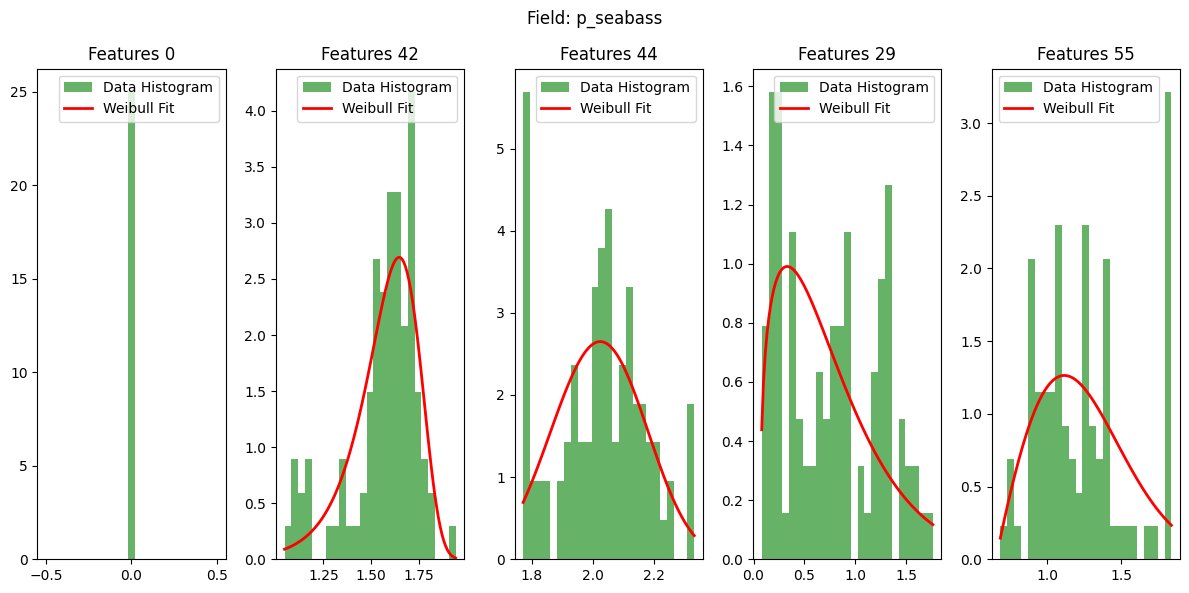

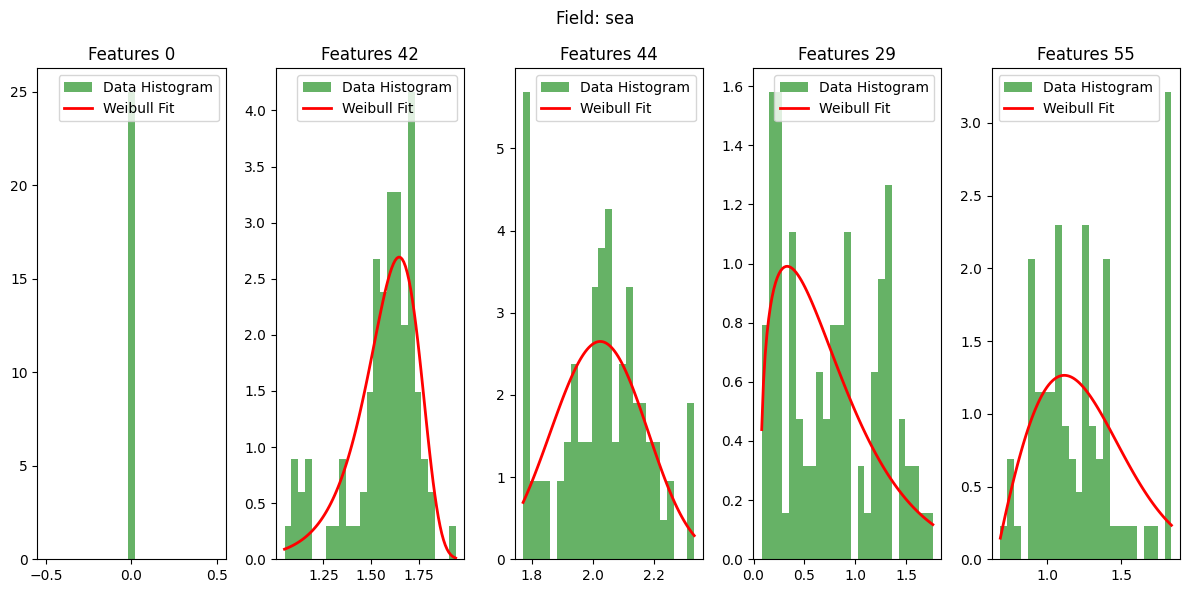

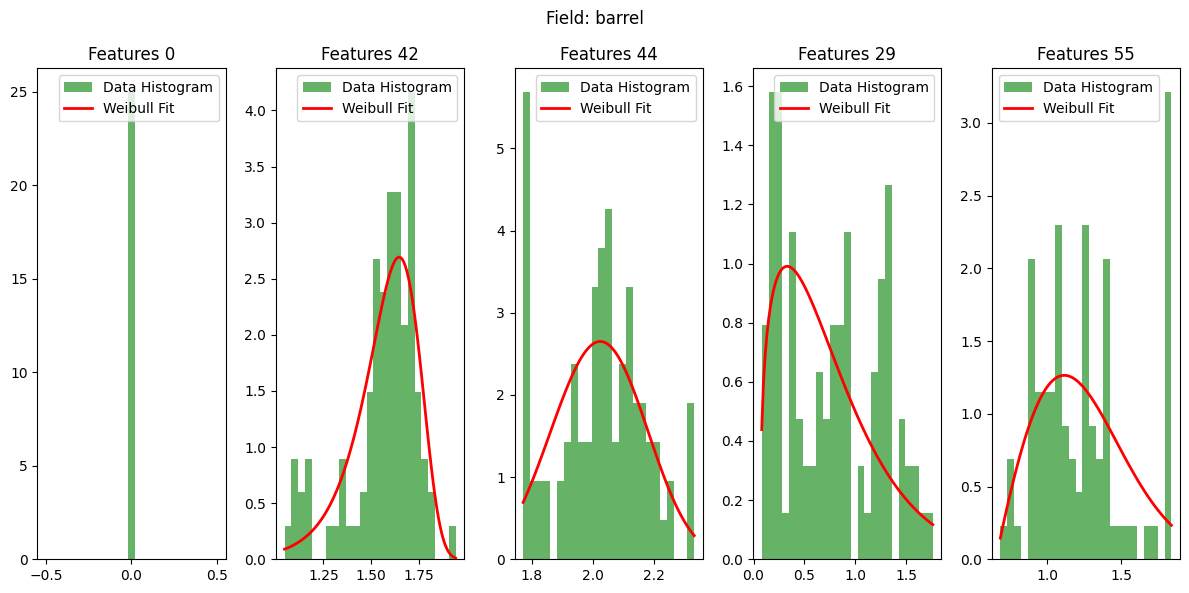

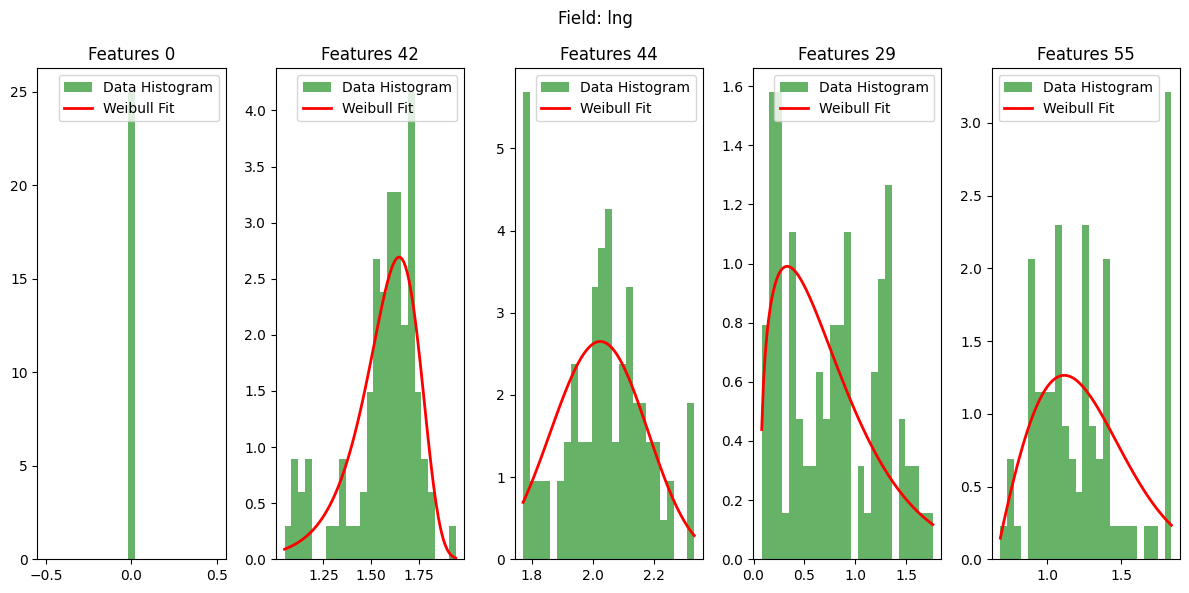

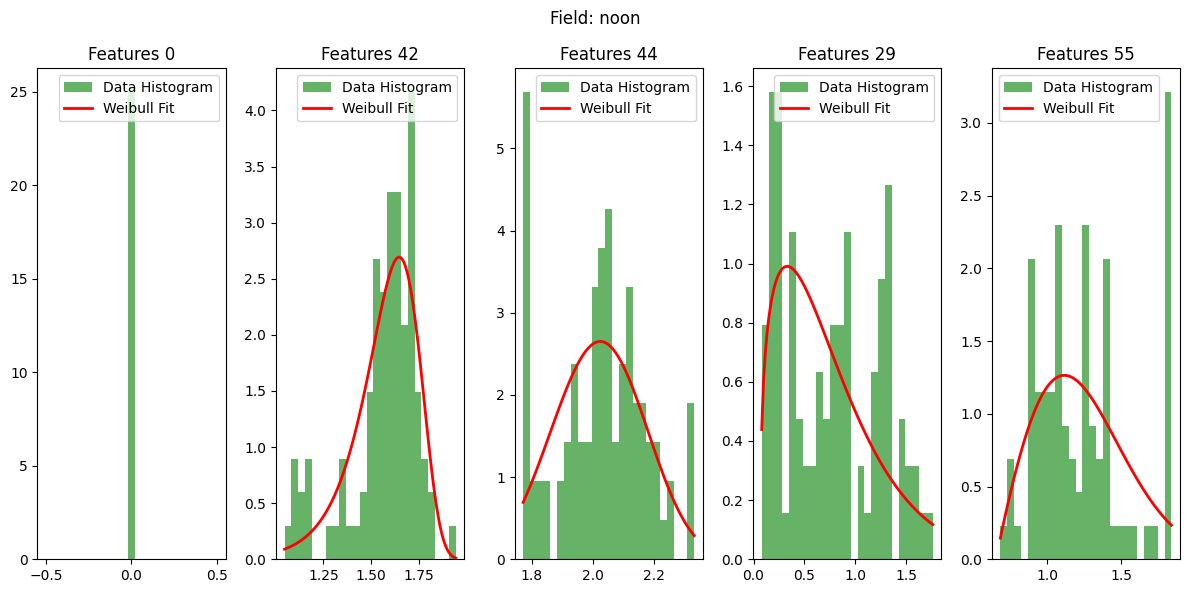

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Approach 1: Randomly sample a few channels and overlay Weibull fit
def plot_sampled_weibull_fit(eucos_dist, num_samples=5, features=False, field_name=''):
    # sampled_channels = np.random.choice(eucos_dist.shape[0], num_samples, replace=False)
    sampled_channels = [2, 13, 4, 8, 10] if not features else [0, 42, 44, 29, 55]
    plt.figure(figsize=(12, 6))
    for i, channel_idx in enumerate(sampled_channels):
        data = eucos_dist[channel_idx]
        # Fit a Weibull distribution to the data
        params = weibull_min.fit(data)
        x = np.linspace(np.min(data), np.max(data), 100)
        weibull_pdf = weibull_min.pdf(x, *params)

        # Plot histogram and Weibull fit for the sampled channel
        plt.subplot(1, num_samples, i+1)
        plt.hist(data, bins=25, density=True, alpha=0.6, color='g', label='Data Histogram')
        plt.plot(x, weibull_pdf, 'r-', lw=2, label='Weibull Fit')
        if features==True:
            plt.title(f'Features {channel_idx}')
        else:
            plt.title(f'Channel {channel_idx}')
        plt.legend()
        plt.suptitle(f'Field: {field_name}')
    plt.tight_layout()
    plt.show()
print(field_names)

eucos = per_fields_f_dist[0].get('euclidean')
plot_sampled_weibull_fit(eucos, features=True, field_name=field_names[0])
eucos1 = per_fields_f_dist[0].get('euclidean')
plot_sampled_weibull_fit(eucos1, features=True, field_name=field_names[1])
eucos2 = per_fields_f_dist[0].get('euclidean')
plot_sampled_weibull_fit(eucos2, features=True, field_name=field_names[2])
eucos3 = per_fields_f_dist[0].get('euclidean')
plot_sampled_weibull_fit(eucos3, features=True, field_name=field_names[3])
eucos4 = per_fields_f_dist[0].get('euclidean')
plot_sampled_weibull_fit(eucos4, features=True, field_name=field_names[4])

## OSDN preprocessing/MAV_Compute.py

In [37]:
# Gather all the testing samples latent space
# for image reconstructoin mse was under consideration

autoencoder.eval()  # Set model to evaluation mode

images_latent = []
with torch.no_grad():  # No need for gradients during evaluation
    for imgs in testing_loader:
        imgs:torch.Tensor = imgs.to(device)
        
        # Just for Type hint
        recon_imgs:torch.Tensor = None

        # Forward pass through the autoencoder
        latent, recon_imgs = autoencoder(imgs) # type: ignore
        # latent shape (batch size, channel, h, w) -> (batch size, channel, h*w)
        latent:torch.Tensor = latent.view((latent.shape[0], latent.shape[1], latent.shape[2]*latent.shape[2]))
        images_latent.append(latent)

images_latent = torch.cat(images_latent, dim=0)
images_latent_np = images_latent.squeeze().cpu().numpy()
print(images_latent.shape, images_latent_np.shape)


torch.Size([200, 128, 144]) (200, 128, 144)


In [38]:
# compute_mean_vector(MAV)
latent_channels_number = images_latent_np.shape[1]
channel_mean_vec = []
for channelid in range(latent_channels_number):
    channel = []
    for feature in images_latent_np:
        channel += [feature[channelid, :]]
    channel = np.asarray(channel)   # shape (N, 1, f)
    assert channel.shape[0] == images_latent_np.shape[0]
    channel_mean_vec += [np.mean(channel, axis=0)]
channel_mean_vec = np.asarray(channel_mean_vec)
print(channel_mean_vec.shape)

(128, 144)


## OSDN preprocessing/compute_distances.py

In [39]:
# Gather all the testing samples latent space
# for image reconstructoin mse was under consideration

autoencoder.eval()  # Set model to evaluation mode

images_latent = []
with torch.no_grad():  # No need for gradients during evaluation
    for imgs in testing_loader:
        imgs:torch.Tensor = imgs.to(device)
        
        # Just for Type hint
        recon_imgs:torch.Tensor = None

        # Forward pass through the autoencoder
        latent, recon_imgs = autoencoder(imgs) # type: ignore
        # latent shape (batch size, channel, h, w) -> (batch size, channel, h*w)
        latent:torch.Tensor = latent.view((latent.shape[0], latent.shape[1], latent.shape[2]*latent.shape[2]))
        images_latent.append(latent)

images_latent = torch.cat(images_latent, dim=0)
images_latent_np = images_latent.squeeze().cpu().numpy()
print(images_latent.shape, images_latent_np.shape)

torch.Size([200, 128, 144]) (200, 128, 144)


In [42]:
# compute channel distances
import scipy.spatial.distance as spd
eucos_dist = []
eu_dist = []
cos_dist = []

latent_channels_number = images_latent_np.shape[1]
for channel in range(latent_channels_number):
    eu_channel, cos_channel, eu_cos_channel = [], [], []
    for feature in images_latent_np:
        eu_channel += [spd.euclidean(channel_mean_vec[channel, :], feature[channel, :])]
        cos_channel += [spd.cosine(channel_mean_vec[channel, :], feature[channel, :])]
        eu_cos_channel += [spd.euclidean(channel_mean_vec[channel, :], feature[channel, :])/200. +
                           spd.cosine(channel_mean_vec[channel, :], feature[channel, :])]

    eu_dist += [eu_channel]
    cos_dist += [cos_channel]
    eucos_dist += [eu_cos_channel]

eucos_dist = np.asarray(eucos_dist)
eu_dist = np.asarray(eu_dist)
cos_dist = np.asarray(cos_dist)

assert eucos_dist.shape[0] == 128
assert eu_dist.shape[0] == 128
assert cos_dist.shape[0] == 128
assert eucos_dist.shape[1] == images_latent_np.shape[0]
assert eu_dist.shape[1] == images_latent_np.shape[0]
assert cos_dist.shape[1] == images_latent_np.shape[0]

channel_distances = {'eucos': eucos_dist, 'cosine': cos_dist, 'eudlidean':eu_dist}

In [46]:
a = [1,2,3,4,5,6,7,8,9]
b = a[-4:]
b

[6, 7, 8, 9]

In [45]:
import libmr
# weibull tailfitting
WEIBULL_TAIL_SIZE = 20
distance_type = 'eucos'

weibull_model = {}
category = 'test_weibull'

distance_scores = channel_distances.get(distance_type)
for channel in range(latent_channels_number):
    mr = libmr.MR()
    tail_to_fit = sorted(distance_scores[channel, :])[-WEIBULL_TAIL_SIZE:]
    mr.fit_high(tail_to_fit, len(tail_to_fit))
    weibull_model[category]['weibull_model'] += [mr]

In [ ]:
# get distance between current channel and mean vector

# obtain w_score fot the distance and compute probability of the distance
# being unknown wrt to mean training vector and channel distances for
# category and channel under consideration
